In [1]:
import numpy as np

import pandas as pd

from sklearn.model_selection import KFold

from sklearn.metrics import mean_squared_error

import xgboost as xgb

import math
import feature_engineering as fe

import matplotlib.pyplot as plt
import seaborn as sns

/Library/Python/2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [11]:
INPUT_PATH = '../input/'
OUTPUT_PATH = '../output/'


def load_data():
    train = pd.read_csv(INPUT_PATH + 'trainv1.csv')
    train['target'] = train['target'].map(lambda x: data_log(x))
    submit = pd.read_csv(INPUT_PATH + 'submitv1.csv')
    return train, submit


def get_xgb_imp(xgb, feat_names):
    from numpy import array
    imp_vals = xgb.get_fscore()
    imp_dict = {feat_names[i]:float(imp_vals.get('f'+str(i),0.)) for i in range(len(feat_names))}
    total = array(imp_dict.values()).sum()
    return {k:v/total for k,v in imp_dict.items()}


def merge_dic(dicts):
    ret = {}
    for dict in dicts:
        for key in dict:
            val = dict[key]
            ret[key] = ret[key]+val if key in ret else val
    return ret

def data_log(x):
    if x <= 0:
        return 0
    else:
        return np.math.log(x + 1, 5)

In [12]:
print('begin to load data')
train, submit = load_data()
train, submit = fe.add_cate_features(train, submit)
train, submit = fe.add_param_features(train, submit)
train, submit = fe.add_dow_features(train, submit)
kfold = 10
skf = KFold(n_splits=kfold,shuffle=True, random_state=42)

begin to load data


In [13]:
params = {
        'objective': 'reg:linear',
        'max_depth': 6,
        'colsample_bytree': 0.8,
        'subsample': 0.8,
        'eta': 0.025,
        'gamma': 1,
        'reg_alpha': 0.5,
        'reg_lambda': 0.8,
        'eval_metric': 'rmse',
        'min_child_weight': 2,
        'silent': 1,
        'nthread': 6
    }



In [14]:

cum= ['consume_counts_sum','consume_amounts_sum','click_counts_sum','workdays','weekends']
   
actives = ['dev_median_loan_amount_cum','median_loan_amount_cum','dev_median_loan_amount','median_loan_amount'
,'median_three_loan_amount','dev_three_median_loan_amount','dev_three_median_limit']    
features_to_remove = ['uid', 'active_date' ]+cum+actives
# features_to_remove = ['active_date' ]+cum+actives
all_features = [x for x in train.columns if not x in features_to_remove+['target']]

# remove uid, try
X = train.drop(features_to_remove+['target'], axis=1).values
y = train.target.values

sub_id = submit.uid.values
to_submit = submit.drop(features_to_remove, axis=1)

sub = pd.DataFrame()
sub['uid'] = sub_id
sub['target'] = np.zeros_like(sub_id)

scores = []

importances = []

In [15]:
kfold = 10
skf = KFold(n_splits=kfold,shuffle=True, random_state=42)

for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_valid = X[train_index], X[test_index]
    y_train, y_valid = y[train_index], y[test_index]
    # Convert our data into XGBoost format
    d_train = xgb.DMatrix(X_train, y_train)
    d_valid = xgb.DMatrix(X_valid, y_valid)
    d_submit = xgb.DMatrix(to_submit.values)
    watchlist = [(d_train, 'train'), (d_valid, 'valid')]
    mdl = xgb.train(params, d_train, 4000, watchlist, early_stopping_rounds = 70, verbose_eval = 50)

    f_importance = get_xgb_imp(mdl,all_features)
    print(f_importance)
    importances.append(f_importance)

    valid_pred = mdl.predict(d_valid, ntree_limit = mdl.best_ntree_limit)
    score_this = np.sqrt(mean_squared_error(valid_pred, y_valid))
    print(score_this)
    scores.append(score_this)

    print('[Fold %d/%d Prediciton:]' % (i + 1, kfold))
    # Predict on our test data
    p_test = mdl.predict(d_submit, ntree_limit=mdl.best_ntree_limit)

    sub['target'] += p_test / kfold

[0]	train-rmse:2.45704	valid-rmse:2.47308
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 70 rounds.
[50]	train-rmse:1.86977	valid-rmse:1.87404
[100]	train-rmse:1.7999	valid-rmse:1.80911
[150]	train-rmse:1.7858	valid-rmse:1.80153
[200]	train-rmse:1.77864	valid-rmse:1.80034
[250]	train-rmse:1.77318	valid-rmse:1.79995
[300]	train-rmse:1.76836	valid-rmse:1.79983
[350]	train-rmse:1.76449	valid-rmse:1.79966
[400]	train-rmse:1.75998	valid-rmse:1.79956
[450]	train-rmse:1.75607	valid-rmse:1.7996
Stopping. Best iteration:
[421]	train-rmse:1.75846	valid-rmse:1.79956

{'dev_three_click_count_cum': 0.010880469172004012, 'active_day_of_week': 0.0089127247472798824, 'avg_click_count_cum': 0.0086426421791804924, 'avg_loan_amount': 0.0055945674820588008, 'plannum': 0.032641407516012036, 'sex': 0.00054016513619878077, 'dow_2': 0.032718573964040439, 'dev_actived_months': 0.011690716876302184, 'dev_click_count_cum': 0.0

1.80782321297
[Fold 2/10 Prediciton:]
[0]	train-rmse:2.45745	valid-rmse:2.46976
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 70 rounds.
[50]	train-rmse:1.8677	valid-rmse:1.88692
[100]	train-rmse:1.79783	valid-rmse:1.82642
[150]	train-rmse:1.78396	valid-rmse:1.81998
[200]	train-rmse:1.77639	valid-rmse:1.81899
[250]	train-rmse:1.77102	valid-rmse:1.81863
[300]	train-rmse:1.76639	valid-rmse:1.81858
[350]	train-rmse:1.76192	valid-rmse:1.81842
[400]	train-rmse:1.75771	valid-rmse:1.8185
Stopping. Best iteration:
[347]	train-rmse:1.76221	valid-rmse:1.81839

{'dev_three_click_count_cum': 0.011972137570744449, 'active_day_of_week': 0.0089246843709185897, 'avg_click_count_cum': 0.0088376142794949937, 'avg_loan_amount': 0.0047017849368741838, 'plannum': 0.035263387026556375, 'sex': 0.00043535045711797995, 'dow_2': 0.029690901175446233, 'dev_actived_months': 0.013321723987810187, 'dev_click_count_cum': 0.012451

1.79890996119
[Fold 4/10 Prediciton:]
[0]	train-rmse:2.45994	valid-rmse:2.44849
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 70 rounds.
[50]	train-rmse:1.86952	valid-rmse:1.87264
[100]	train-rmse:1.79943	valid-rmse:1.81225
[150]	train-rmse:1.78536	valid-rmse:1.8056
[200]	train-rmse:1.77788	valid-rmse:1.80418
[250]	train-rmse:1.77255	valid-rmse:1.80362
[300]	train-rmse:1.76816	valid-rmse:1.8032
[350]	train-rmse:1.7641	valid-rmse:1.80331
[400]	train-rmse:1.75963	valid-rmse:1.803
[450]	train-rmse:1.75533	valid-rmse:1.80323
Stopping. Best iteration:
[406]	train-rmse:1.75908	valid-rmse:1.80297

{'dev_three_click_count_cum': 0.012489690114292447, 'active_day_of_week': 0.0082479085660421819, 'avg_click_count_cum': 0.0078158752602018773, 'avg_loan_amount': 0.0050665724048544834, 'plannum': 0.033973528141078513, 'sex': 0.00058913632614587016, 'dow_2': 0.030949295000196379, 'dev_actived_months': 0.0124111386

1.80054590097
[Fold 6/10 Prediciton:]
[0]	train-rmse:2.46003	valid-rmse:2.44591
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 70 rounds.
[50]	train-rmse:1.86789	valid-rmse:1.88562
[100]	train-rmse:1.79767	valid-rmse:1.82858
[150]	train-rmse:1.78361	valid-rmse:1.82261
[200]	train-rmse:1.77605	valid-rmse:1.82183
[250]	train-rmse:1.77046	valid-rmse:1.82143
[300]	train-rmse:1.76619	valid-rmse:1.82137
[350]	train-rmse:1.7619	valid-rmse:1.82146
Stopping. Best iteration:
[305]	train-rmse:1.76568	valid-rmse:1.8213

{'dev_three_click_count_cum': 0.01221946351200039, 'active_day_of_week': 0.0087629618811158171, 'avg_click_count_cum': 0.012024731025753372, 'avg_loan_amount': 0.0044788471836814175, 'plannum': 0.036901806143809938, 'sex': 0.00043814809405579085, 'dow_2': 0.029794070395793779, 'dev_actived_months': 0.011829998539506352, 'dev_click_count_cum': 0.010710286743585999, 'limit_get_promoted_ever': 0.002

1.79372570209
[Fold 8/10 Prediciton:]
[0]	train-rmse:2.45915	valid-rmse:2.45572
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 70 rounds.
[50]	train-rmse:1.87066	valid-rmse:1.86642
[100]	train-rmse:1.80075	valid-rmse:1.80098
[150]	train-rmse:1.78693	valid-rmse:1.79337
[200]	train-rmse:1.77948	valid-rmse:1.79192
[250]	train-rmse:1.77416	valid-rmse:1.79146
[300]	train-rmse:1.76918	valid-rmse:1.79137
[350]	train-rmse:1.76496	valid-rmse:1.79139
Stopping. Best iteration:
[318]	train-rmse:1.7676	valid-rmse:1.79131

{'dev_three_click_count_cum': 0.011089883975583617, 'active_day_of_week': 0.008946461022319557, 'avg_click_count_cum': 0.0097385955920041012, 'avg_loan_amount': 0.0047994035692651791, 'plannum': 0.035599459484646566, 'sex': 0.00032617305810540051, 'dow_2': 0.027538325334327384, 'dev_actived_months': 0.011136480126741531, 'dev_click_count_cum': 0.012021806998741905, 'limit_get_promoted_ever': 0.0

1.80369518636
[Fold 10/10 Prediciton:]


In [16]:
imp_sum = merge_dic(importances)
sort_rec = sorted(imp_sum.items(), key=lambda x:x[1])
print(sort_rec)

print('cv avg scores %s' % np.mean(scores))

[('median_three_loan_amount', 0.0), ('dev_three_median_loan_amount', 0.0), ('dev_three_median_limit', 0.0), ('median_limit', 0.00023156983054098279), ('median_three_limit', 0.00029607590985261651), ('median_three_loan_amount_cum', 0.00057779880484356747), ('avg_three_limit', 0.0012015900385680481), ('median_actived_months', 0.0029239309625245847), ('sex', 0.004705716350803222), ('active_year', 0.0055801761419743308), ('limit_get_promoted', 0.0079156872490830071), ('median_three_actived_months', 0.0085050077328895114), ('dev_three_median_loan_amount_cum', 0.011515501474466451), ('dev_median_limit', 0.013491616995421703), ('median_click_count', 0.015487447703166398), ('limit_get_promoted_ever', 0.01938276200893093), ('avg_limit', 0.020305340932194785), ('limit', 0.022622370122182277), ('median_three_click_count', 0.033324342217476821), ('age', 0.035890185895731785), ('avg_click_count', 0.042368039206701583), ('dev_median_actived_months', 0.042538982099579674), ('avg_loan_amount_cum', 0.0

In [8]:
scores

[1.7997760837305647,
 1.8081780599470274,
 1.8174306407601386,
 1.7980952193745952,
 1.803293675072575,
 1.7991284354408601,
 1.8202622970552014,
 1.7940496112707014,
 1.7897634416506685,
 1.8031774497461537]

In [9]:
from datetime import datetime
sub.loc[sub.target < 0, 'target'] = 0
sub.to_csv(OUTPUT_PATH +"subByXgb{}.csv".format(datetime.now().strftime('%Y%m%d_%H%M%S')), index=False)

In [326]:
all_features = [x for x in train.columns if not x in ['uid', 'target', 'active_date']]

X = train.drop(['uid', 'target', 'active_date'], axis=1)
y = train.target

In [348]:
xgb_params = {
        'objective': ['reg:linear'],
        'learning_rate': [0.025],
        'max_depth': [6],
        'min_child_weight': [2],
        'silent': [1],
        'subsample': [ 0.8],
        'colsample_bytree': [0.8],
        'n_estimators': [400],
        'gamma': [1,3],
        'reg_alpha': [0.5,0.8],
        'reg_lambda': [0.8,1.3] 
    }

In [349]:

from sklearn.model_selection import GridSearchCV

import xgboost as xgb


In [350]:
modelXgboost = xgb.XGBRegressor()

    # Run the grid search
grid_obj_xgb = GridSearchCV(modelXgboost, xgb_params, cv=KFold(n_splits=5, shuffle=True, random_state=42), n_jobs=2, verbose=2, refit=True,scoring='mean_squared_error')
grid_obj_xgb = grid_obj_xgb.fit(X, y)


Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] reg_alpha=0.5, colsample_bytree=0.8, silent=1, learning_rate=0.025, min_child_weight=2, n_estimators=400, subsample=0.8, reg_lambda=0.8, objective=reg:linear, max_depth=6, gamma=1 
[CV] reg_alpha=0.5, colsample_bytree=0.8, silent=1, learning_rate=0.025, min_child_weight=2, n_estimators=400, subsample=0.8, reg_lambda=0.8, objective=reg:linear, max_depth=6, gamma=1 


/Library/Python/2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Library/Python/2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Library/Python/2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Library/Python/2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  reg_alpha=0.5, colsample_bytree=0.8, silent=1, learning_rate=0.025, min_child_weight=2, n_estimators=400, subsample=0.8, reg_lambda=0.8, objective=reg:linear, max_depth=6, gamma=1, total= 1.4min
[CV] reg_alpha=0.5, colsample_bytree=0.8, silent=1, learning_rate=0.025, min_child_weight=2, n_estimators=400, subsample=0.8, reg_lambda=0.8, objective=reg:linear, max_depth=6, gamma=1 
[CV]  reg_alpha=0.5, colsample_bytree=0.8, silent=1, learning_rate=0.025, min_child_weight=2, n_estimators=400, subsample=0.8, reg_lambda=0.8, objective=reg:linear, max_depth=6, gamma=1, total= 1.4min
[CV] reg_alpha=0.5, colsample_bytree=0.8, silent=1, learning_rate=0.025, min_child_weight=2, n_estimators=400, subsample=0.8, reg_lambda=0.8, objective=reg:linear, max_depth=6, gamma=1 


/Library/Python/2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Library/Python/2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Library/Python/2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Library/Python/2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  reg_alpha=0.5, colsample_bytree=0.8, silent=1, learning_rate=0.025, min_child_weight=2, n_estimators=400, subsample=0.8, reg_lambda=0.8, objective=reg:linear, max_depth=6, gamma=1, total= 1.5min
[CV] reg_alpha=0.5, colsample_bytree=0.8, silent=1, learning_rate=0.025, min_child_weight=2, n_estimators=400, subsample=0.8, reg_lambda=0.8, objective=reg:linear, max_depth=6, gamma=1 
[CV]  reg_alpha=0.5, colsample_bytree=0.8, silent=1, learning_rate=0.025, min_child_weight=2, n_estimators=400, subsample=0.8, reg_lambda=0.8, objective=reg:linear, max_depth=6, gamma=1, total= 1.5min
[CV] reg_alpha=0.5, colsample_bytree=0.8, silent=1, learning_rate=0.025, min_child_weight=2, n_estimators=400, subsample=0.8, reg_lambda=1.3, objective=reg:linear, max_depth=6, gamma=1 


/Library/Python/2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Library/Python/2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  reg_alpha=0.5, colsample_bytree=0.8, silent=1, learning_rate=0.025, min_child_weight=2, n_estimators=400, subsample=0.8, reg_lambda=0.8, objective=reg:linear, max_depth=6, gamma=1, total= 1.4min
[CV] reg_alpha=0.5, colsample_bytree=0.8, silent=1, learning_rate=0.025, min_child_weight=2, n_estimators=400, subsample=0.8, reg_lambda=1.3, objective=reg:linear, max_depth=6, gamma=1 


/Library/Python/2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Library/Python/2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  reg_alpha=0.5, colsample_bytree=0.8, silent=1, learning_rate=0.025, min_child_weight=2, n_estimators=400, subsample=0.8, reg_lambda=1.3, objective=reg:linear, max_depth=6, gamma=1, total= 1.5min
[CV] reg_alpha=0.5, colsample_bytree=0.8, silent=1, learning_rate=0.025, min_child_weight=2, n_estimators=400, subsample=0.8, reg_lambda=1.3, objective=reg:linear, max_depth=6, gamma=1 


/Library/Python/2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Library/Python/2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Library/Python/2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Library/Python/2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  reg_alpha=0.5, colsample_bytree=0.8, silent=1, learning_rate=0.025, min_child_weight=2, n_estimators=400, subsample=0.8, reg_lambda=1.3, objective=reg:linear, max_depth=6, gamma=1, total= 1.6min
[CV] reg_alpha=0.5, colsample_bytree=0.8, silent=1, learning_rate=0.025, min_child_weight=2, n_estimators=400, subsample=0.8, reg_lambda=1.3, objective=reg:linear, max_depth=6, gamma=1 
[CV]  reg_alpha=0.5, colsample_bytree=0.8, silent=1, learning_rate=0.025, min_child_weight=2, n_estimators=400, subsample=0.8, reg_lambda=1.3, objective=reg:linear, max_depth=6, gamma=1, total= 1.5min
[CV] reg_alpha=0.5, colsample_bytree=0.8, silent=1, learning_rate=0.025, min_child_weight=2, n_estimators=400, subsample=0.8, reg_lambda=1.3, objective=reg:linear, max_depth=6, gamma=1 


/Library/Python/2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Library/Python/2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Library/Python/2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Library/Python/2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  reg_alpha=0.5, colsample_bytree=0.8, silent=1, learning_rate=0.025, min_child_weight=2, n_estimators=400, subsample=0.8, reg_lambda=1.3, objective=reg:linear, max_depth=6, gamma=1, total= 1.5min
[CV] reg_alpha=0.8, colsample_bytree=0.8, silent=1, learning_rate=0.025, min_child_weight=2, n_estimators=400, subsample=0.8, reg_lambda=0.8, objective=reg:linear, max_depth=6, gamma=1 
[CV]  reg_alpha=0.5, colsample_bytree=0.8, silent=1, learning_rate=0.025, min_child_weight=2, n_estimators=400, subsample=0.8, reg_lambda=1.3, objective=reg:linear, max_depth=6, gamma=1, total= 1.4min
[CV] reg_alpha=0.8, colsample_bytree=0.8, silent=1, learning_rate=0.025, min_child_weight=2, n_estimators=400, subsample=0.8, reg_lambda=0.8, objective=reg:linear, max_depth=6, gamma=1 


/Library/Python/2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Library/Python/2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Library/Python/2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Library/Python/2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  reg_alpha=0.8, colsample_bytree=0.8, silent=1, learning_rate=0.025, min_child_weight=2, n_estimators=400, subsample=0.8, reg_lambda=0.8, objective=reg:linear, max_depth=6, gamma=1, total= 1.4min
[CV] reg_alpha=0.8, colsample_bytree=0.8, silent=1, learning_rate=0.025, min_child_weight=2, n_estimators=400, subsample=0.8, reg_lambda=0.8, objective=reg:linear, max_depth=6, gamma=1 
[CV]  reg_alpha=0.8, colsample_bytree=0.8, silent=1, learning_rate=0.025, min_child_weight=2, n_estimators=400, subsample=0.8, reg_lambda=0.8, objective=reg:linear, max_depth=6, gamma=1, total= 1.4min
[CV] reg_alpha=0.8, colsample_bytree=0.8, silent=1, learning_rate=0.025, min_child_weight=2, n_estimators=400, subsample=0.8, reg_lambda=0.8, objective=reg:linear, max_depth=6, gamma=1 


/Library/Python/2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Library/Python/2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Library/Python/2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Library/Python/2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  reg_alpha=0.8, colsample_bytree=0.8, silent=1, learning_rate=0.025, min_child_weight=2, n_estimators=400, subsample=0.8, reg_lambda=0.8, objective=reg:linear, max_depth=6, gamma=1, total= 1.3min
[CV] reg_alpha=0.8, colsample_bytree=0.8, silent=1, learning_rate=0.025, min_child_weight=2, n_estimators=400, subsample=0.8, reg_lambda=0.8, objective=reg:linear, max_depth=6, gamma=1 
[CV]  reg_alpha=0.8, colsample_bytree=0.8, silent=1, learning_rate=0.025, min_child_weight=2, n_estimators=400, subsample=0.8, reg_lambda=0.8, objective=reg:linear, max_depth=6, gamma=1, total= 1.3min
[CV] reg_alpha=0.8, colsample_bytree=0.8, silent=1, learning_rate=0.025, min_child_weight=2, n_estimators=400, subsample=0.8, reg_lambda=1.3, objective=reg:linear, max_depth=6, gamma=1 


/Library/Python/2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Library/Python/2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Library/Python/2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Library/Python/2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  reg_alpha=0.8, colsample_bytree=0.8, silent=1, learning_rate=0.025, min_child_weight=2, n_estimators=400, subsample=0.8, reg_lambda=0.8, objective=reg:linear, max_depth=6, gamma=1, total= 1.4min
[CV] reg_alpha=0.8, colsample_bytree=0.8, silent=1, learning_rate=0.025, min_child_weight=2, n_estimators=400, subsample=0.8, reg_lambda=1.3, objective=reg:linear, max_depth=6, gamma=1 
[CV]  reg_alpha=0.8, colsample_bytree=0.8, silent=1, learning_rate=0.025, min_child_weight=2, n_estimators=400, subsample=0.8, reg_lambda=1.3, objective=reg:linear, max_depth=6, gamma=1, total= 1.5min
[CV] reg_alpha=0.8, colsample_bytree=0.8, silent=1, learning_rate=0.025, min_child_weight=2, n_estimators=400, subsample=0.8, reg_lambda=1.3, objective=reg:linear, max_depth=6, gamma=1 


/Library/Python/2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Library/Python/2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Library/Python/2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Library/Python/2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  reg_alpha=0.8, colsample_bytree=0.8, silent=1, learning_rate=0.025, min_child_weight=2, n_estimators=400, subsample=0.8, reg_lambda=1.3, objective=reg:linear, max_depth=6, gamma=1, total= 1.3min
[CV] reg_alpha=0.8, colsample_bytree=0.8, silent=1, learning_rate=0.025, min_child_weight=2, n_estimators=400, subsample=0.8, reg_lambda=1.3, objective=reg:linear, max_depth=6, gamma=1 
[CV]  reg_alpha=0.8, colsample_bytree=0.8, silent=1, learning_rate=0.025, min_child_weight=2, n_estimators=400, subsample=0.8, reg_lambda=1.3, objective=reg:linear, max_depth=6, gamma=1, total= 1.3min
[CV] reg_alpha=0.8, colsample_bytree=0.8, silent=1, learning_rate=0.025, min_child_weight=2, n_estimators=400, subsample=0.8, reg_lambda=1.3, objective=reg:linear, max_depth=6, gamma=1 


/Library/Python/2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Library/Python/2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Library/Python/2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Library/Python/2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  reg_alpha=0.8, colsample_bytree=0.8, silent=1, learning_rate=0.025, min_child_weight=2, n_estimators=400, subsample=0.8, reg_lambda=1.3, objective=reg:linear, max_depth=6, gamma=1, total= 1.3min
[CV] reg_alpha=0.5, colsample_bytree=0.8, silent=1, learning_rate=0.025, min_child_weight=2, n_estimators=400, subsample=0.8, reg_lambda=0.8, objective=reg:linear, max_depth=6, gamma=3 
[CV]  reg_alpha=0.8, colsample_bytree=0.8, silent=1, learning_rate=0.025, min_child_weight=2, n_estimators=400, subsample=0.8, reg_lambda=1.3, objective=reg:linear, max_depth=6, gamma=1, total= 1.3min
[CV] reg_alpha=0.5, colsample_bytree=0.8, silent=1, learning_rate=0.025, min_child_weight=2, n_estimators=400, subsample=0.8, reg_lambda=0.8, objective=reg:linear, max_depth=6, gamma=3 


/Library/Python/2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Library/Python/2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Library/Python/2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Library/Python/2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  reg_alpha=0.5, colsample_bytree=0.8, silent=1, learning_rate=0.025, min_child_weight=2, n_estimators=400, subsample=0.8, reg_lambda=0.8, objective=reg:linear, max_depth=6, gamma=3, total= 1.5min
[CV] reg_alpha=0.5, colsample_bytree=0.8, silent=1, learning_rate=0.025, min_child_weight=2, n_estimators=400, subsample=0.8, reg_lambda=0.8, objective=reg:linear, max_depth=6, gamma=3 
[CV]  reg_alpha=0.5, colsample_bytree=0.8, silent=1, learning_rate=0.025, min_child_weight=2, n_estimators=400, subsample=0.8, reg_lambda=0.8, objective=reg:linear, max_depth=6, gamma=3, total= 1.5min
[CV] reg_alpha=0.5, colsample_bytree=0.8, silent=1, learning_rate=0.025, min_child_weight=2, n_estimators=400, subsample=0.8, reg_lambda=0.8, objective=reg:linear, max_depth=6, gamma=3 


/Library/Python/2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Library/Python/2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Library/Python/2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Library/Python/2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  reg_alpha=0.5, colsample_bytree=0.8, silent=1, learning_rate=0.025, min_child_weight=2, n_estimators=400, subsample=0.8, reg_lambda=0.8, objective=reg:linear, max_depth=6, gamma=3, total= 1.4min
[CV] reg_alpha=0.5, colsample_bytree=0.8, silent=1, learning_rate=0.025, min_child_weight=2, n_estimators=400, subsample=0.8, reg_lambda=0.8, objective=reg:linear, max_depth=6, gamma=3 
[CV]  reg_alpha=0.5, colsample_bytree=0.8, silent=1, learning_rate=0.025, min_child_weight=2, n_estimators=400, subsample=0.8, reg_lambda=0.8, objective=reg:linear, max_depth=6, gamma=3, total= 1.4min
[CV] reg_alpha=0.5, colsample_bytree=0.8, silent=1, learning_rate=0.025, min_child_weight=2, n_estimators=400, subsample=0.8, reg_lambda=1.3, objective=reg:linear, max_depth=6, gamma=3 


/Library/Python/2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Library/Python/2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Library/Python/2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  reg_alpha=0.5, colsample_bytree=0.8, silent=1, learning_rate=0.025, min_child_weight=2, n_estimators=400, subsample=0.8, reg_lambda=0.8, objective=reg:linear, max_depth=6, gamma=3, total= 1.5min
[CV] reg_alpha=0.5, colsample_bytree=0.8, silent=1, learning_rate=0.025, min_child_weight=2, n_estimators=400, subsample=0.8, reg_lambda=1.3, objective=reg:linear, max_depth=6, gamma=3 


/Library/Python/2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  reg_alpha=0.5, colsample_bytree=0.8, silent=1, learning_rate=0.025, min_child_weight=2, n_estimators=400, subsample=0.8, reg_lambda=1.3, objective=reg:linear, max_depth=6, gamma=3, total= 1.6min
[CV] reg_alpha=0.5, colsample_bytree=0.8, silent=1, learning_rate=0.025, min_child_weight=2, n_estimators=400, subsample=0.8, reg_lambda=1.3, objective=reg:linear, max_depth=6, gamma=3 


/Library/Python/2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Library/Python/2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Library/Python/2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Library/Python/2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  reg_alpha=0.5, colsample_bytree=0.8, silent=1, learning_rate=0.025, min_child_weight=2, n_estimators=400, subsample=0.8, reg_lambda=1.3, objective=reg:linear, max_depth=6, gamma=3, total= 1.5min
[CV] reg_alpha=0.5, colsample_bytree=0.8, silent=1, learning_rate=0.025, min_child_weight=2, n_estimators=400, subsample=0.8, reg_lambda=1.3, objective=reg:linear, max_depth=6, gamma=3 
[CV]  reg_alpha=0.5, colsample_bytree=0.8, silent=1, learning_rate=0.025, min_child_weight=2, n_estimators=400, subsample=0.8, reg_lambda=1.3, objective=reg:linear, max_depth=6, gamma=3, total= 1.5min
[CV] reg_alpha=0.5, colsample_bytree=0.8, silent=1, learning_rate=0.025, min_child_weight=2, n_estimators=400, subsample=0.8, reg_lambda=1.3, objective=reg:linear, max_depth=6, gamma=3 


/Library/Python/2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Library/Python/2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Library/Python/2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Library/Python/2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  reg_alpha=0.5, colsample_bytree=0.8, silent=1, learning_rate=0.025, min_child_weight=2, n_estimators=400, subsample=0.8, reg_lambda=1.3, objective=reg:linear, max_depth=6, gamma=3, total= 1.5min
[CV] reg_alpha=0.8, colsample_bytree=0.8, silent=1, learning_rate=0.025, min_child_weight=2, n_estimators=400, subsample=0.8, reg_lambda=0.8, objective=reg:linear, max_depth=6, gamma=3 
[CV]  reg_alpha=0.5, colsample_bytree=0.8, silent=1, learning_rate=0.025, min_child_weight=2, n_estimators=400, subsample=0.8, reg_lambda=1.3, objective=reg:linear, max_depth=6, gamma=3, total= 1.5min
[CV] reg_alpha=0.8, colsample_bytree=0.8, silent=1, learning_rate=0.025, min_child_weight=2, n_estimators=400, subsample=0.8, reg_lambda=0.8, objective=reg:linear, max_depth=6, gamma=3 


/Library/Python/2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Library/Python/2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Library/Python/2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Library/Python/2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  reg_alpha=0.8, colsample_bytree=0.8, silent=1, learning_rate=0.025, min_child_weight=2, n_estimators=400, subsample=0.8, reg_lambda=0.8, objective=reg:linear, max_depth=6, gamma=3, total= 1.6min
[CV] reg_alpha=0.8, colsample_bytree=0.8, silent=1, learning_rate=0.025, min_child_weight=2, n_estimators=400, subsample=0.8, reg_lambda=0.8, objective=reg:linear, max_depth=6, gamma=3 
[CV]  reg_alpha=0.8, colsample_bytree=0.8, silent=1, learning_rate=0.025, min_child_weight=2, n_estimators=400, subsample=0.8, reg_lambda=0.8, objective=reg:linear, max_depth=6, gamma=3, total= 1.6min
[CV] reg_alpha=0.8, colsample_bytree=0.8, silent=1, learning_rate=0.025, min_child_weight=2, n_estimators=400, subsample=0.8, reg_lambda=0.8, objective=reg:linear, max_depth=6, gamma=3 


/Library/Python/2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Library/Python/2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Library/Python/2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Library/Python/2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  reg_alpha=0.8, colsample_bytree=0.8, silent=1, learning_rate=0.025, min_child_weight=2, n_estimators=400, subsample=0.8, reg_lambda=0.8, objective=reg:linear, max_depth=6, gamma=3, total= 1.2min
[CV] reg_alpha=0.8, colsample_bytree=0.8, silent=1, learning_rate=0.025, min_child_weight=2, n_estimators=400, subsample=0.8, reg_lambda=0.8, objective=reg:linear, max_depth=6, gamma=3 
[CV]  reg_alpha=0.8, colsample_bytree=0.8, silent=1, learning_rate=0.025, min_child_weight=2, n_estimators=400, subsample=0.8, reg_lambda=0.8, objective=reg:linear, max_depth=6, gamma=3, total= 1.2min
[CV] reg_alpha=0.8, colsample_bytree=0.8, silent=1, learning_rate=0.025, min_child_weight=2, n_estimators=400, subsample=0.8, reg_lambda=1.3, objective=reg:linear, max_depth=6, gamma=3 


/Library/Python/2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Library/Python/2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Library/Python/2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  reg_alpha=0.8, colsample_bytree=0.8, silent=1, learning_rate=0.025, min_child_weight=2, n_estimators=400, subsample=0.8, reg_lambda=0.8, objective=reg:linear, max_depth=6, gamma=3, total= 1.2min
[CV] reg_alpha=0.8, colsample_bytree=0.8, silent=1, learning_rate=0.025, min_child_weight=2, n_estimators=400, subsample=0.8, reg_lambda=1.3, objective=reg:linear, max_depth=6, gamma=3 


/Library/Python/2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  reg_alpha=0.8, colsample_bytree=0.8, silent=1, learning_rate=0.025, min_child_weight=2, n_estimators=400, subsample=0.8, reg_lambda=1.3, objective=reg:linear, max_depth=6, gamma=3, total= 1.3min
[CV] reg_alpha=0.8, colsample_bytree=0.8, silent=1, learning_rate=0.025, min_child_weight=2, n_estimators=400, subsample=0.8, reg_lambda=1.3, objective=reg:linear, max_depth=6, gamma=3 


/Library/Python/2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Library/Python/2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Library/Python/2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Library/Python/2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  reg_alpha=0.8, colsample_bytree=0.8, silent=1, learning_rate=0.025, min_child_weight=2, n_estimators=400, subsample=0.8, reg_lambda=1.3, objective=reg:linear, max_depth=6, gamma=3, total= 1.5min
[CV] reg_alpha=0.8, colsample_bytree=0.8, silent=1, learning_rate=0.025, min_child_weight=2, n_estimators=400, subsample=0.8, reg_lambda=1.3, objective=reg:linear, max_depth=6, gamma=3 


[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed: 28.4min


[CV]  reg_alpha=0.8, colsample_bytree=0.8, silent=1, learning_rate=0.025, min_child_weight=2, n_estimators=400, subsample=0.8, reg_lambda=1.3, objective=reg:linear, max_depth=6, gamma=3, total= 1.4min
[CV] reg_alpha=0.8, colsample_bytree=0.8, silent=1, learning_rate=0.025, min_child_weight=2, n_estimators=400, subsample=0.8, reg_lambda=1.3, objective=reg:linear, max_depth=6, gamma=3 


/Library/Python/2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Library/Python/2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Library/Python/2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Library/Python/2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  reg_alpha=0.8, colsample_bytree=0.8, silent=1, learning_rate=0.025, min_child_weight=2, n_estimators=400, subsample=0.8, reg_lambda=1.3, objective=reg:linear, max_depth=6, gamma=3, total= 1.2min
[CV]  reg_alpha=0.8, colsample_bytree=0.8, silent=1, learning_rate=0.025, min_child_weight=2, n_estimators=400, subsample=0.8, reg_lambda=1.3, objective=reg:linear, max_depth=6, gamma=3, total= 1.2min


[Parallel(n_jobs=2)]: Done  40 out of  40 | elapsed: 29.7min finished


In [351]:
clf = grid_obj_xgb.best_estimator_
grid_obj_xgb.best_params_

{'colsample_bytree': 0.8,
 'gamma': 1,
 'learning_rate': 0.025,
 'max_depth': 6,
 'min_child_weight': 2,
 'n_estimators': 400,
 'objective': 'reg:linear',
 'reg_alpha': 0.5,
 'reg_lambda': 0.8,
 'silent': 1,
 'subsample': 0.8}

In [10]:
all_features

['age',
 'sex',
 'limit',
 'active_month',
 'active_year',
 'active_day_of_week',
 'consume_count',
 'consume_amount',
 'loan_amount',
 'loan_count',
 'plannum',
 'click_count',
 'limit_get_promoted',
 'limit_get_promoted_ever',
 'consume_count_cum',
 'consume_amount_cum',
 'loan_amount_cum',
 'loan_count_cum',
 'click_count_cum',
 'plannum_cum',
 'actived_months',
 'avg_limit',
 'median_limit',
 'dev_limit',
 'dev_median_limit',
 'avg_consume_count',
 'median_consume_count',
 'dev_consume_count',
 'dev_median_consume_count',
 'avg_consume_amount',
 'median_consume_amount',
 'dev_consume_amount',
 'dev_median_consume_amount',
 'avg_loan_amount',
 'dev_loan_amount',
 'avg_loan_count',
 'median_loan_count',
 'dev_loan_count',
 'dev_median_loan_count',
 'avg_plannum',
 'median_plannum',
 'dev_plannum',
 'dev_median_plannum',
 'avg_click_count',
 'median_click_count',
 'dev_click_count',
 'dev_median_click_count',
 'avg_actived_months',
 'median_actived_months',
 'dev_actived_months',
 'de

In [33]:
all_cols

['cate_0', 'cate_1', 'cate_2', 'cat_counts']

In [35]:
plt.figure(figsize=(12,8))
sns.distplot(train.target.values, bins=10, kde=False)
plt.xlabel('loan_sum', fontsize=12)
plt.show()

In [51]:
train.sort_values(by='target', ascending=True)['target']

136489    0.000000
171445    0.000000
171448    0.000000
171449    0.000000
171450    0.000000
171451    0.000000
171452    0.000000
171453    0.000000
171454    0.000000
171455    0.000000
171456    0.000000
171458    0.000000
171459    0.000000
171460    0.000000
171461    0.000000
171462    0.000000
171463    0.000000
171464    0.000000
171465    0.000000
171466    0.000000
171467    0.000000
171468    0.000000
171469    0.000000
171470    0.000000
171472    0.000000
171473    0.000000
171444    0.000000
171474    0.000000
171443    0.000000
171440    0.000000
            ...   
249876    7.541306
98220     7.552192
211715    7.552192
221455    7.573093
264647    7.577818
198668    7.577818
212867    7.584062
237565    7.584062
229381    7.584062
235594    7.584062
208766    7.584062
37142     7.584062
55579     7.584062
47395     7.584062
124181    7.596366
16976     7.614377
53608     7.637607
41553     7.639883
33407     7.643282
215393    7.643282
215174    7.670901
132546    7.

In [62]:
mdl

In [75]:
ver['mae'] = (ver['predict'] - ver['real']).map(lambda x: abs(x))

In [70]:
ver = pd.DataFrame()
# ver['uid'] = X_valid['uid'].values


In [71]:
nd1 = mdl.predict(d_valid, ntree_limit = mdl.best_ntree_limit)
nd2 = y_valid
ver['predict'] =  nd1
ver['real'] = nd2


In [72]:
ver

,predict,real
0,3.644095,0.000000
1,0.243864,0.000000
2,0.448551,0.000000
3,2.068521,6.153414
4,3.682263,5.781982
5,1.645592,4.292651
6,0.156728,0.000000
7,0.334569,0.000000
8,0.231443,0.000000
9,1.761627,0.000000


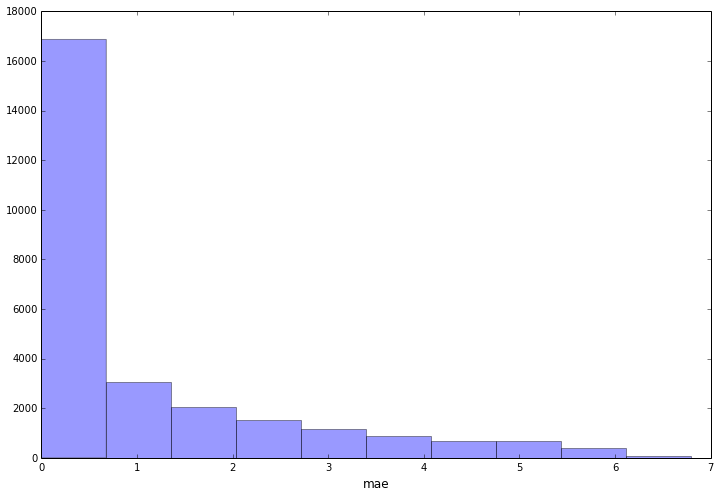

In [76]:
plt.figure(figsize=(12,8))
sns.distplot(ver.mae.values, bins=10, kde=False)
plt.xlabel('mae', fontsize=12)
plt.show()

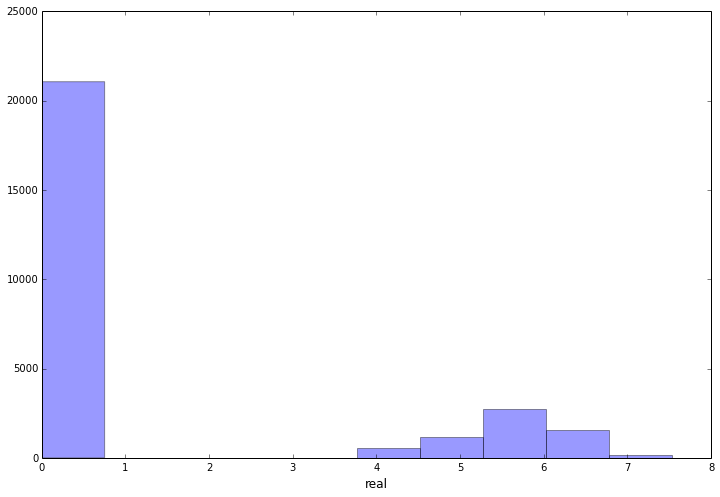

In [77]:
plt.figure(figsize=(12,8))
sns.distplot(ver.real.values, bins=10, kde=False)
plt.xlabel('real', fontsize=12)
plt.show()

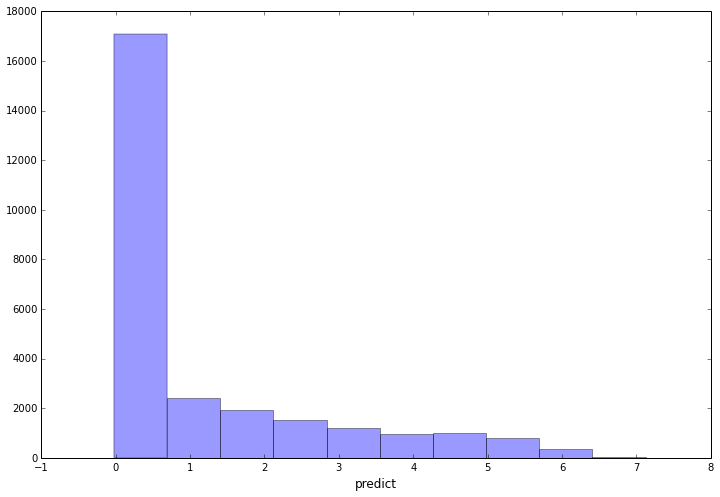

In [78]:
plt.figure(figsize=(12,8))
sns.distplot(ver.predict.values, bins=10, kde=False)
plt.xlabel('predict', fontsize=12)
plt.show()

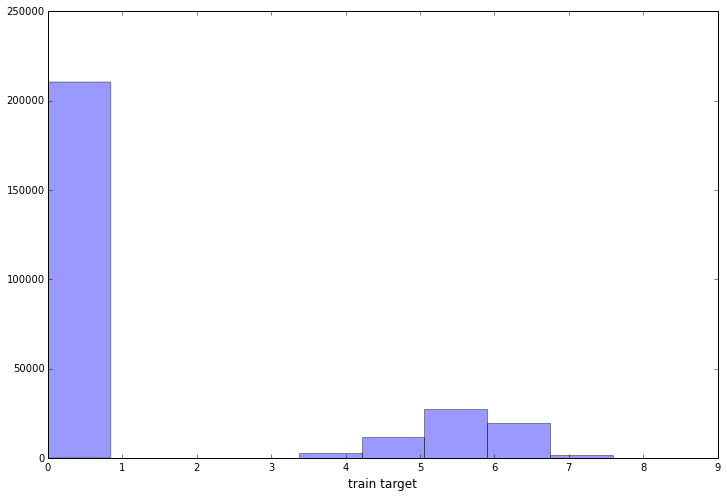

In [69]:
plt.figure(figsize=(12,8))
sns.distplot(train.target.values, bins=10, kde=False)
plt.xlabel('train target', fontsize=12)
plt.show()

In [79]:
def map_res(x, thread):
    if x <= thread:
        return 0
    else:
        x

In [137]:
def using_where(x):
    return np.where(x > 2, x, 0)

In [108]:
xx = np.array([1, 2, 3, 4, 5,0.1])

In [109]:
squares = np.array([using_where(xi) for xi in xx])

In [110]:
squares

array([ 0.,  2.,  3.,  4.,  5.,  0.])

In [138]:
valid_pred = mdl.predict(d_valid, ntree_limit = mdl.best_ntree_limit)
valid_pred = np.array([using_where(xi) for xi in valid_pred])

In [139]:
        score_this = np.sqrt(mean_squared_error(valid_pred, y_valid))
        print(score_this)
        scores.append(score_this)

1.89706965912


In [22]:
f1 = '../output/subByLgb20171201_135533qtyfixed.csv'
f2 = '../output/subByXgb20171201_153049dowremoved.csv'

df1 = pd.read_csv(f1, header=None)
df2 = pd.read_csv(f2, header=None)



In [23]:
sub = pd.DataFrame()
sub['uid'] = df1[0]


In [24]:
w=0.2
sub['target'] = df1[1]*w+df2[1]*(1-w)
word=2

In [25]:
from datetime import datetime
sub.loc[sub.target < 0, 'target'] = 0
sub.to_csv('../output/' +"subByLgbXgbAvg{}.csv".format(word), index=False)

In [73]:
import numpy as np

import pandas as pd


INPUT_PATH = '../input/'
OUTPUT_PATH = '../output/'

In [74]:
    users = pd.read_csv(INPUT_PATH + 't_user.csv')
    loans = pd.read_csv(INPUT_PATH + 't_loan.csv')

        # origin price
    loans.loan_amount = 5**loans.loan_amount - 1
    users.limit = 5 ** users.limit -1

    # loans
    loans['Date'] = pd.to_datetime(loans['loan_time'], errors='coerce')
    loans['transaction_month'] = loans['Date'].dt.month

In [75]:
    loans['lam_plan'] = loans['loan_amount'] / loans['plannum']

    loans['8_lmp_pay'] = 0
    loans['9_lmp_pay'] = 0
    loans['10_lmp_pay'] = 0
    loans['11_lmp_pay'] = 0

    loans['8_lmp_reste'] = 0
    loans['9_lmp_reste'] = 0
    loans['10_lmp_reste'] = 0
    loans['11_lmp_reste'] = 0

    loans.loc[loans.transaction_month == 8, '8_lmp_reste'] = loans.loan_amount

    loans.loc[loans.transaction_month == 8, '9_lmp_pay'] = loans.lam_plan
    loans.loc[(loans.transaction_month == 8) & (loans.plannum>1), '9_lmp_reste'] = (loans.plannum-1) * loans.lam_plan
    loans.loc[loans.transaction_month == 9, '9_lmp_reste'] = loans.loan_amount

    loans.loc[(loans.transaction_month == 8) & (loans.plannum>1), '10_lmp_pay'] = loans.lam_plan
    loans.loc[loans.transaction_month == 9, '10_lmp_pay'] = loans.lam_plan
    loans.loc[(loans.transaction_month == 8) & (loans.plannum>2), '10_lmp_reste'] =  (loans.plannum-2) * loans.lam_plan
    loans.loc[(loans.transaction_month == 9) & (loans.plannum>1), '10_lmp_reste'] =  (loans.plannum-1) * loans.lam_plan
    loans.loc[loans.transaction_month == 10, '10_lmp_reste'] = loans.loan_amount

    loans.loc[(loans.transaction_month == 8) & (loans.plannum>2), '11_lmp_pay'] = loans.lam_plan
    loans.loc[(loans.transaction_month == 9) & (loans.plannum>1), '11_lmp_pay'] = loans.lam_plan
    loans.loc[loans.transaction_month == 10, '11_lmp_pay'] = loans.lam_plan
    loans.loc[(loans.transaction_month == 8) & (loans.plannum>3), '11_lmp_reste'] =  (loans.plannum-3) * loans.lam_plan
    loans.loc[(loans.transaction_month == 9) & (loans.plannum>2), '11_lmp_reste'] =  (loans.plannum-2) * loans.lam_plan
    loans.loc[(loans.transaction_month == 10) & (loans.plannum>1), '11_lmp_reste'] =  (loans.plannum-1) * loans.lam_plan
    loans.loc[loans.transaction_month == 11, '11_lmp_reste'] = loans.loan_amount

    loans_new = loans.groupby(by=["uid"], as_index=False)["8_lmp_pay",'8_lmp_reste', "9_lmp_pay", '9_lmp_reste',
    '10_lmp_pay','10_lmp_reste','11_lmp_pay','11_lmp_reste'].sum()

In [76]:
loans[(loans.uid==41227) & (loans.transaction_month==8)]

,uid,loan_time,loan_amount,plannum,Date,transaction_month,lam_plan,8_lmp_pay,9_lmp_pay,10_lmp_pay,11_lmp_pay,8_lmp_reste,9_lmp_reste,10_lmp_reste,11_lmp_reste
9,41227,2016-08-03 02:26:52,3500.0,3,2016-08-03 02:26:52,8,1166.666667,0,1166.666667,1166.666667,1166.666667,3500.0,2333.333333,1166.666667,0.0
463,41227,2016-08-04 14:15:32,500.0,1,2016-08-04 14:15:32,8,500.000000,0,500.000000,0.000000,0.000000,500.0,0.000000,0.000000,0.0
835,41227,2016-08-05 21:23:12,1500.0,1,2016-08-05 21:23:12,8,1500.000000,0,1500.000000,0.000000,0.000000,1500.0,0.000000,0.000000,0.0
6615,41227,2016-08-27 00:28:06,1000.0,1,2016-08-27 00:28:06,8,1000.000000,0,1000.000000,0.000000,0.000000,1000.0,0.000000,0.000000,0.0
34247,41227,2016-08-04 13:01:34,500.0,1,2016-08-04 13:01:34,8,500.000000,0,500.000000,0.000000,0.000000,500.0,0.000000,0.000000,0.0
71530,41227,2016-08-16 20:28:28,900.0,1,2016-08-16 20:28:28,8,900.000000,0,900.000000,0.000000,0.000000,900.0,0.000000,0.000000,0.0
71535,41227,2016-08-16 20:36:42,1100.0,1,2016-08-16 20:36:42,8,1100.000000,0,1100.000000,0.000000,0.000000,1100.0,0.000000,0.000000,0.0
108111,41227,2016-08-27 12:52:43,1000.0,1,2016-08-27 12:52:43,8,1000.000000,0,1000.000000,0.000000,0.000000,1000.0,0.000000,0.000000,0.0


In [78]:
loans[(loans.uid==41227) & (loans.transaction_month==9)]

,uid,loan_time,loan_amount,plannum,Date,transaction_month,lam_plan,8_lmp_pay,9_lmp_pay,10_lmp_pay,11_lmp_pay,8_lmp_reste,9_lmp_reste,10_lmp_reste,11_lmp_reste
8308,41227,2016-09-01 18:34:03,900.0,1,2016-09-01 18:34:03,9,900.0,0,0.0,900.0,0.0,0.0,900.0,0.0,0.0
14723,41227,2016-09-22 20:00:43,900.0,1,2016-09-22 20:00:43,9,900.0,0,0.0,900.0,0.0,0.0,900.0,0.0,0.0
16584,41227,2016-09-29 10:27:12,1000.0,1,2016-09-29 10:27:12,9,1000.0,0,0.0,1000.0,0.0,0.0,1000.0,0.0,0.0
50744,41227,2016-09-30 20:22:24,1000.0,1,2016-09-30 20:22:24,9,1000.0,0,0.0,1000.0,0.0,0.0,1000.0,0.0,0.0
110882,41227,2016-09-05 18:07:41,1600.0,1,2016-09-05 18:07:41,9,1600.0,0,0.0,1600.0,0.0,0.0,1600.0,0.0,0.0
116024,41227,2016-09-22 20:06:39,500.0,1,2016-09-22 20:06:39,9,500.0,0,0.0,500.0,0.0,0.0,500.0,0.0,0.0
149700,41227,2016-09-22 20:57:59,1000.0,1,2016-09-22 20:57:59,9,1000.0,0,0.0,1000.0,0.0,0.0,1000.0,0.0,0.0
181528,41227,2016-09-15 20:17:20,1000.0,1,2016-09-15 20:17:20,9,1000.0,0,0.0,1000.0,0.0,0.0,1000.0,0.0,0.0


In [79]:
loans[(loans.uid==41227) & (loans.transaction_month==10)]

,uid,loan_time,loan_amount,plannum,Date,transaction_month,lam_plan,8_lmp_pay,9_lmp_pay,10_lmp_pay,11_lmp_pay,8_lmp_reste,9_lmp_reste,10_lmp_reste,11_lmp_reste
18496,41227,2016-10-05 17:06:29,500.0,1,2016-10-05 17:06:29,10,500.000000,0,0.0,0.0,500.000000,0.0,0.0,500.0,0.000000
57264,41227,2016-10-22 11:09:30,1000.0,1,2016-10-22 11:09:30,10,1000.000000,0,0.0,0.0,1000.000000,0.0,0.0,1000.0,0.000000
85709,41227,2016-10-04 14:29:17,1000.0,1,2016-10-04 14:29:17,10,1000.000000,0,0.0,0.0,1000.000000,0.0,0.0,1000.0,0.000000
153901,41227,2016-10-06 17:31:08,500.0,1,2016-10-06 17:31:08,10,500.000000,0,0.0,0.0,500.000000,0.0,0.0,500.0,0.000000
187179,41227,2016-10-04 11:42:59,1000.0,3,2016-10-04 11:42:59,10,333.333333,0,0.0,0.0,333.333333,0.0,0.0,1000.0,666.666667


In [80]:
loans[(loans.uid==41227) & (loans.transaction_month==11)]

,uid,loan_time,loan_amount,plannum,Date,transaction_month,lam_plan,8_lmp_pay,9_lmp_pay,10_lmp_pay,11_lmp_pay,8_lmp_reste,9_lmp_reste,10_lmp_reste,11_lmp_reste
127808,41227,2016-11-04 12:33:59,2500.0,1,2016-11-04 12:33:59,11,2500.0,0,0.0,0.0,0.0,0.0,0.0,0.0,2500.0


In [77]:
loans_new[loans_new.uid==41227]

,uid,8_lmp_pay,8_lmp_reste,9_lmp_pay,9_lmp_reste,10_lmp_pay,10_lmp_reste,11_lmp_pay,11_lmp_reste
16505,41227,0,10000.0,7666.666667,10233.333333,9066.666667,5166.666667,4500.0,3166.666667


In [28]:
loans.plannum.value_counts()

1     109041
12     45759
6      29706
3      18396
Name: plannum, dtype: int64

In [82]:
    user_info = pd.read_csv(OUTPUT_PATH + 'user_info.csv')
    lap = pd.read_csv(OUTPUT_PATH +"loan_pay_next.csv")
    #add loan amount pay next month
    user_info = user_info.merge(lap,how='left', on="uid")

In [89]:
user_info[user_info.uid==41227][["8_lmp_pay",'8_lmp_reste', "9_lmp_pay", '9_lmp_reste',
    '10_lmp_pay','10_lmp_reste','11_lmp_pay','11_lmp_reste']]

,8_lmp_pay,8_lmp_reste,9_lmp_pay,9_lmp_reste,10_lmp_pay,10_lmp_reste,11_lmp_pay,11_lmp_reste
61797,0.0,10000.0,7666.666667,10233.333333,9066.666667,5166.666667,4500.0,3166.666667


In [1]:
    loans_date = loans.groupby(by=["uid", "transaction_month"], as_index=False)['loan_amount','plannum'].median()
    loans_date = loans_date.pivot_table(['loan_day_active'], ['uid'], 'transaction_month', fill_value=0)
    loans_date.reset_index(drop=False, inplace=True)
    loans_date.columns = ['{}_{}'.format(i[1], i[0]) for i in loans_date.columns]
    loans_date = loans_date.rename(index=str, columns={"_uid": "uid"})

NameError: name 'loans' is not defined